In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train_label.pkl', 'train_image.pkl', 'test_image.pkl']


In [2]:
import pickle


with open('../input/train_image.pkl', 'rb') as f:
    train = pickle.load(f)

In [3]:
len(train)

8000

In [4]:
with open('../input/train_label.pkl', 'rb') as f:
    label = pickle.load(f)

In [5]:
import numpy as np
import pandas as pd

In [6]:
label = np.array(label)

In [7]:
len(label)

8000

In [8]:
np.unique(label)

array([0, 2, 3, 6])

In [9]:
train = np.array(train)

In [10]:
np.unique(train)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [11]:
train.shape

(8000, 784)

In [12]:
with open('../input/test_image.pkl', 'rb') as f:
    test = pickle.load(f)

In [13]:
test = np.array(test)

In [14]:
test.shape

(2000, 784)

In [15]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

In [16]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

Using TensorFlow backend.


In [17]:
train = train.reshape(8000, 28,28)

In [18]:
test = test.reshape(2000,28,28)

In [19]:
label_dict = {
 0: 'A',
 2: 'C',
 3: 'D',
 6: 'G',
}

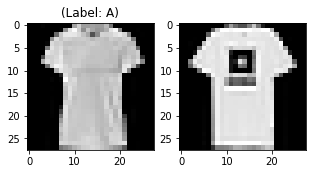

In [20]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train[10], (28,28))
curr_lbl = label[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test[10], (28,28))
#curr_lbl = label[10]
plt.imshow(curr_img, cmap='gray')
#plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [21]:
train_data = train.reshape(-1, 28,28, 1)
test_data = test.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((8000, 28, 28, 1), (2000, 28, 28, 1))

In [22]:
train_data.dtype, test_data.dtype

(dtype('int64'), dtype('int64'))

In [23]:
np.max(train_data), np.max(test_data)

(255, 255)

In [24]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [25]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [26]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [73]:
batch_size = 64
epochs = 200
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 7

In [74]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [75]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [76]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_37 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_38 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [77]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 6400 samples, validate on 1600 samples
Epoch 1/200
6400/6400 [==============================] - 6s 933us/step - loss: 0.0442 - val_loss: 0.0780
Epoch 2/200
6400/6400 [==============================] - 2s 374us/step - loss: 0.0222 - val_loss: 0.1277
Epoch 3/200
6400/6400 [==============================] - 2s 379us/step - loss: 0.0167 - val_loss: 0.0276
Epoch 4/200
6400/6400 [==============================] - 2s 373us/step - loss: 0.0140 - val_loss: 0.0235
Epoch 5/200
6400/6400 [==============================] - 2s 374us/step - loss: 0.0123 - val_loss: 0.0181
Epoch 6/200
6400/6400 [==============================] - 2s 372us/step - loss: 0.0111 - val_loss: 0.0129
Epoch 7/200
6400/6400 [==============================] - 2s 378us/step - loss: 0.0103 - val_loss: 0.0152
Epoch 8/200
6400/6400 [==============================] - 2s 375us/step - loss: 0.0091 - val_loss: 0.0139
Epoch 9/200
6400/6400 [==============================] - 2s 378us/step - loss: 0.0089 - val_loss: 0.0101
Epoch 1

Epoch 78/200
6400/6400 [==============================] - 2s 375us/step - loss: 0.0028 - val_loss: 0.0034
Epoch 79/200
6400/6400 [==============================] - 2s 377us/step - loss: 0.0028 - val_loss: 0.0036
Epoch 80/200
6400/6400 [==============================] - 2s 375us/step - loss: 0.0028 - val_loss: 0.0040
Epoch 81/200
6400/6400 [==============================] - 2s 374us/step - loss: 0.0028 - val_loss: 0.0039
Epoch 82/200
6400/6400 [==============================] - 2s 376us/step - loss: 0.0027 - val_loss: 0.0040
Epoch 83/200
6400/6400 [==============================] - 2s 376us/step - loss: 0.0027 - val_loss: 0.0037
Epoch 84/200
6400/6400 [==============================] - 2s 375us/step - loss: 0.0027 - val_loss: 0.0036
Epoch 85/200
6400/6400 [==============================] - 2s 374us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 86/200
6400/6400 [==============================] - 2s 376us/step - loss: 0.0026 - val_loss: 0.0040
Epoch 87/200
6400/6400 [======================

Epoch 155/200
6400/6400 [==============================] - 2s 373us/step - loss: 0.0017 - val_loss: 0.0036
Epoch 156/200
6400/6400 [==============================] - 2s 373us/step - loss: 0.0017 - val_loss: 0.0034
Epoch 157/200
6400/6400 [==============================] - 2s 374us/step - loss: 0.0017 - val_loss: 0.0036
Epoch 158/200
6400/6400 [==============================] - 2s 374us/step - loss: 0.0017 - val_loss: 0.0036
Epoch 159/200
6400/6400 [==============================] - 2s 374us/step - loss: 0.0017 - val_loss: 0.0036
Epoch 160/200
6400/6400 [==============================] - 2s 376us/step - loss: 0.0017 - val_loss: 0.0047
Epoch 161/200
6400/6400 [==============================] - 2s 374us/step - loss: 0.0017 - val_loss: 0.0046
Epoch 162/200
6400/6400 [==============================] - 2s 372us/step - loss: 0.0017 - val_loss: 0.0036
Epoch 163/200
6400/6400 [==============================] - 3s 392us/step - loss: 0.0017 - val_loss: 0.0037
Epoch 164/200
6400/6400 [============

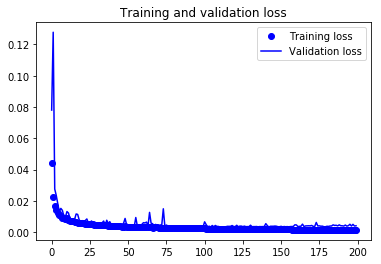

In [78]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [79]:
autoencoder.save_weights('autoencoder.h5')

In [80]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = keras.utils.np_utils.to_categorical(label)


# Display the change for category label using one-hot encoding
print('Original label:', label[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0. 0.]


In [81]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

In [82]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((6400, 28, 28, 1), (1600, 28, 28, 1), (6400, 7), (1600, 7))

In [83]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [84]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [85]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [86]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [87]:
autoencoder.get_weights()[0][1]

array([[[-8.92826021e-02,  1.20219760e-01,  9.46458802e-03,
          6.52166232e-02,  1.85997859e-01, -6.71763197e-02,
         -8.58565941e-02, -1.99856564e-01, -6.24276586e-02,
          1.33293331e-01, -1.68890998e-01,  1.18645422e-01,
          1.93988860e-01,  2.62400568e-01,  7.07430691e-02,
          2.45019019e-01,  1.44162819e-01, -5.77673972e-01,
         -2.58288622e-01, -7.07396120e-02,  6.44430071e-02,
         -1.95830643e-01,  2.10087031e-01, -2.24126223e-02,
          3.00603449e-01,  4.92660552e-02,  6.61354959e-02,
          8.80498514e-02, -5.19504473e-02, -1.57302082e-01,
         -3.81634772e-01, -4.73297609e-04]],

       [[-9.59830638e-03, -1.10451095e-01,  1.40998423e-01,
          2.49244288e-01,  5.32437414e-02,  1.43699288e-01,
          1.87271938e-01, -8.99593085e-02,  1.16814569e-01,
         -3.01000714e-01, -1.00562781e-01, -2.40664959e-01,
          1.41868010e-01, -1.89484492e-01,  2.88667381e-01,
          7.42339417e-02,  2.18929410e-01, -2.63741136

In [88]:
full_model.get_weights()[0][1]

array([[[-8.92826021e-02,  1.20219760e-01,  9.46458802e-03,
          6.52166232e-02,  1.85997859e-01, -6.71763197e-02,
         -8.58565941e-02, -1.99856564e-01, -6.24276586e-02,
          1.33293331e-01, -1.68890998e-01,  1.18645422e-01,
          1.93988860e-01,  2.62400568e-01,  7.07430691e-02,
          2.45019019e-01,  1.44162819e-01, -5.77673972e-01,
         -2.58288622e-01, -7.07396120e-02,  6.44430071e-02,
         -1.95830643e-01,  2.10087031e-01, -2.24126223e-02,
          3.00603449e-01,  4.92660552e-02,  6.61354959e-02,
          8.80498514e-02, -5.19504473e-02, -1.57302082e-01,
         -3.81634772e-01, -4.73297609e-04]],

       [[-9.59830638e-03, -1.10451095e-01,  1.40998423e-01,
          2.49244288e-01,  5.32437414e-02,  1.43699288e-01,
          1.87271938e-01, -8.99593085e-02,  1.16814569e-01,
         -3.01000714e-01, -1.00562781e-01, -2.40664959e-01,
          1.41868010e-01, -1.89484492e-01,  2.88667381e-01,
          7.42339417e-02,  2.18929410e-01, -2.63741136

In [89]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [90]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [91]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_51 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_52 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [92]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 3s 493us/step - loss: 0.5764 - acc: 0.8113 - val_loss: 0.3891 - val_acc: 0.8531
Epoch 2/100
6400/6400 [==============================] - 1s 126us/step - loss: 0.2175 - acc: 0.9191 - val_loss: 0.4111 - val_acc: 0.8425
Epoch 3/100
6400/6400 [==============================] - 1s 125us/step - loss: 0.1088 - acc: 0.9608 - val_loss: 0.4182 - val_acc: 0.8500
Epoch 4/100
6400/6400 [==============================] - 1s 124us/step - loss: 0.0590 - acc: 0.9816 - val_loss: 0.5113 - val_acc: 0.8544
Epoch 5/100
6400/6400 [==============================] - 1s 123us/step - loss: 0.0316 - acc: 0.9909 - val_loss: 0.5072 - val_acc: 0.8562
Epoch 6/100
6400/6400 [==============================] - 1s 130us/step - loss: 0.0108 - acc: 0.9986 - val_loss: 0.5198 - val_acc: 0.8681
Epoch 7/100
6400/6400 [==============================] - 1s 127us/step - loss: 0.0049 - acc: 0.9997 - val_loss: 0.5282 - val_acc: 

In [93]:
full_model.save_weights('autoencoder_classification.h5')

In [94]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [95]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [96]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 6s 886us/step - loss: 0.0756 - acc: 0.9842 - val_loss: 1.1657 - val_acc: 0.8269
Epoch 2/100
6400/6400 [==============================] - 2s 286us/step - loss: 0.0701 - acc: 0.9813 - val_loss: 1.1240 - val_acc: 0.8475
Epoch 3/100
6400/6400 [==============================] - 2s 287us/step - loss: 0.0699 - acc: 0.9814 - val_loss: 1.1396 - val_acc: 0.8281
Epoch 4/100
6400/6400 [==============================] - 2s 284us/step - loss: 0.0575 - acc: 0.9838 - val_loss: 1.0339 - val_acc: 0.8462
Epoch 5/100
6400/6400 [==============================] - 2s 284us/step - loss: 0.0360 - acc: 0.9878 - val_loss: 1.0356 - val_acc: 0.8506
Epoch 6/100
6400/6400 [==============================] - 2s 283us/step - loss: 0.0224 - acc: 0.9930 - val_loss: 0.9913 - val_acc: 0.8525
Epoch 7/100
6400/6400 [==============================] - 2s 286us/step - loss: 0.0089 - acc: 0.9969 - val_loss: 1.0262 - val_acc: 

In [97]:
full_model.save_weights('classification_complete.h5')

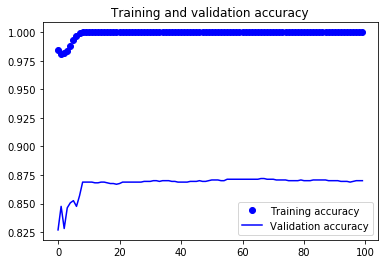

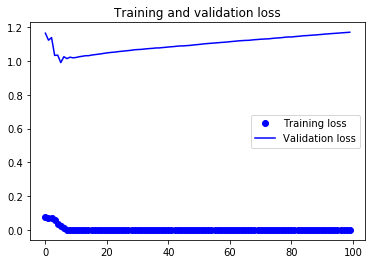

In [98]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the above two plots, you can see that the model is overfitting since there is a big gap between the training and validation loss. In order to address overfitting, you will have to maybe use some regularization techniques like Dropout

In [116]:
predicted_classes = full_model.predict(train_data)

In [117]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

((1600,), (1600, 7))

In [122]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(4)]
print(classification_report(label, predicted_classes,target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.96      0.97      0.97      2000
     Class 1       0.98      0.98      0.98      2000
     Class 2       0.98      0.99      0.99      2000
     Class 3       0.97      0.95      0.96      2000

   micro avg       0.97      0.97      0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



In [123]:
predictions = full_model.predict(test_data)

In [125]:
predictions = np.argmax(np.round(predictions),axis=1)

In [126]:
res = {'image_index':range(0,2000),'class':predictions}

In [127]:
df = pd.DataFrame(res)

In [128]:
df.head()

,image_index,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [1]:
df.to_csv('Pooja_Agarwal.csv')

NameError: name 'df' is not defined